In [2]:
### This notebook is for diagnosis of multilayer breaking wave. ###
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from mpl_toolkits.mplot3d import Axes3D  

In [195]:
# 3D fft: read in data and store as 3D array
filepath = '/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/P0015_CFL01/'
N = 256
time = np.arange(0,40,0.1)
eta_series = np.zeros((time.size,N,N), dtype=np.float32)
for i in range(0, time.size):
    filename = filepath + 'surface/eta_matrix_%g' %time[i]
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    eta_series[i] = eta    
print(eta_series.shape)

(400, 256, 256)


In [196]:
data = eta_series[:,:,:]
dt = 0.1    # sampling frequency, (Hz)
dx = 50./256.     # spatial sampling step along X in (m)
dy = 50./256.      # spatial sampling step along Y in (m)
t_max = dt * data.shape[0]  # s
x_max = dx * data.shape[1]  # m
y_max = dy * data.shape[2]  # m
x = np.linspace(0, x_max, data.shape[1])   # m
y = np.linspace(0, y_max, data.shape[2])   # m
xx,yy = np.meshgrid(x, y, indexing='ij')
omega = np.linspace(-np.pi / dt, np.pi / dt, data.shape[0])                          # frequency (Hz)
kx = np.linspace(-np.pi / dx, np.pi / dx, data.shape[1])  # wavenumber along X axis (rad/mm)
ky = np.linspace(-np.pi / dy, np.pi / dy, data.shape[2])  # wavenumber along Y axis (rad/mm)
Ky, Kx = np.meshgrid(ky, kx, indexing='ij')
Omega, K = np.meshgrid(omega, kx, indexing='ij')

In [197]:
# Fourrier transform along Y, X and T axes to obtain ky, kx, f
spectrum_3d = np.fft.fftn(data)                            
# Apply frequency shift along spatial dimentions 
# that zero-frequency component appears at the center of the spectrum
spectrum_3d = np.fft.fftshift(spectrum_3d, axes=(0,1,2))
F = np.absolute(spectrum_3d)
# spectrum_3d_sh = np.fft.fftshift(spectrum_3d, axes=(1,2))  

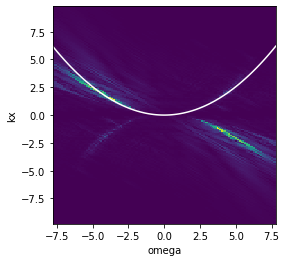

In [203]:
plt.figure(figsize=[4,4])
psd = plt.pcolormesh(Omega[150:-150,50:-50], K[150:-150,50:-50], F[150:-150,50:-50,127])
# cbar = plt.colorbar(psd, label='PSD')
plt.xlabel('omega')
plt.ylabel('kx')
plt.plot(omega[150:-150], omega[150:-150]**2/9.8, 'w')

In [183]:
# time series of 2D fft
filepath = '/home/jiarong/research/projects/multilayer/testing/multigrid_changeheader/trial24/P0015_CFL01/'
N = 256
time = np.arange(0,60,1)
spectrum_2d_series = np.zeros((time.size,N,N), dtype=np.float32)
for i in range(0, time.size):
    filename = filepath + 'surface/eta_matrix_%g' %time[i]
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    spectrum = np.fft.fft2(eta)*(1/N)**2
    F = np.absolute(spectrum)
    F_center = np.fft.fftshift(F, axes=(0,1))
    spectrum_2d_series[i] = F_center

1.5964267e-09


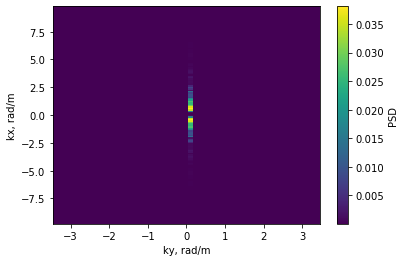

In [184]:
plt.figure(figsize=[6,4])
psd = plt.pcolormesh(Kx[50:-50,100:-100], Ky[50:-50,100:-100], spectrum_2d_series[2,50:-50,100:-100])
cbar = plt.colorbar(psd, label='PSD')
plt.xlabel('ky, rad/m')
plt.ylabel('kx, rad/m')
print(spectrum_2d_series[2,128,127])

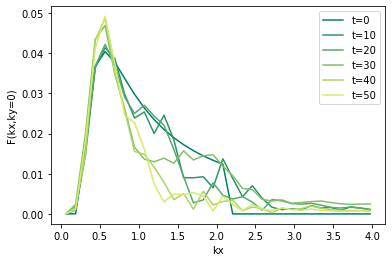

In [194]:
for i in range(0, 60, 10):
    plt.plot(kx[128:160], spectrum_2d_series[i,128:160,128], 
             color=plt.cm.get_cmap('summer')(i/60), label = 't=%g' %time[i])
plt.xlabel('kx')
plt.ylabel('F(kx,ky=0)')
plt.legend()

In [151]:
# Function for average in azimuthal direction; pretty coarse; 
# taken from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

Text(0, 0.5, 'F(k)')

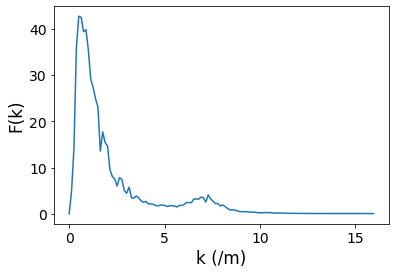

In [278]:
# Rewrite function to convert polar to cartesian and interpolate
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# Interpolate F
# kx=(0:Ld*mfac-1)/mfac/Ld/pix;

# kx=[-kx(idmx+1:-1:2),kx(1:idmx)];
# ky=[-ky(idmy+1:-1:2),ky(1:idmy)];
# [kxm,kym]=meshgrid(kx,ky);
# t=(0:128)/128*2*pi;%definition of angular coordinate
# [k,theta]=meshgrid(kx(end-idmx+1:end),t(1:128));%creation of polar grid
# [kxp,kyp]=pol2cart(theta,k);%going from cartesian to polar/creating the grid
# spm=zeros(idmx,nfft*mfact);%this will be the 1d space spectrum
# for i=1:nfft*mfact
#     spp=fftshift(sp(:,:,i));
#     sppp=interp2(kxm,kym,spp,kxp,kyp);
#     spm(:,i)=sum(sppp,1)*(theta(2,1)-theta(1,1)).*k(1,:);%integration over angle
# end;
# kk=k(1,:);

L = 50; N = 256
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
kx = np.fft.fftshift(wavenumber)
ky = kx
kx_tile, ky_tile = np.meshgrid(kx,ky)
theta = np.arange(0,N/2)/(N/2)*2*np.pi
k = wavenumber[0:128]
k_tile, theta_tile = np.meshgrid(k,theta)
kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)

from scipy import interpolate
# f = interpolate.interp2d(kx_tile, ky_tile, F_center)
# F_center_polar = f(kxp_tile, kyp_tile)
f = interpolate.RectBivariateSpline(kx, ky, F_center)
F_center_polar = f.ev(kxp_tile, kyp_tile)
F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])
plt.plot(k, F_center_polar_integrated*k)
plt.xlabel('k (/m)'); plt.ylabel('F(k)')

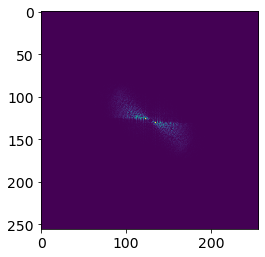

In [153]:
F_center_fitted = f.ev(kx_tile,ky_tile)
plt.imshow(F_center_fitted)

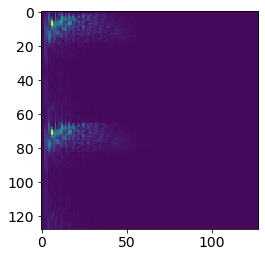

In [154]:
plt.imshow(F_center_polar)

Text(0, 0.5, 'F(k)')

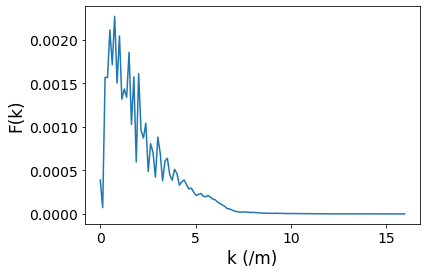

In [155]:
F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])
plt.plot(k, F_center_polar_integrated)
plt.xlabel('k (/m)'); plt.ylabel('F(k)')

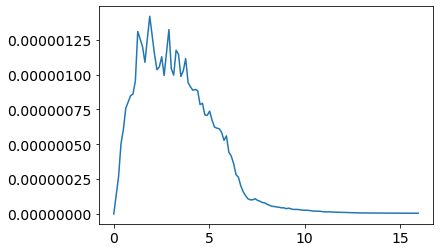

In [156]:
F_k = azimuthalAverage(F_center)
plt.plot(k, F_k[0:128]/256*k)

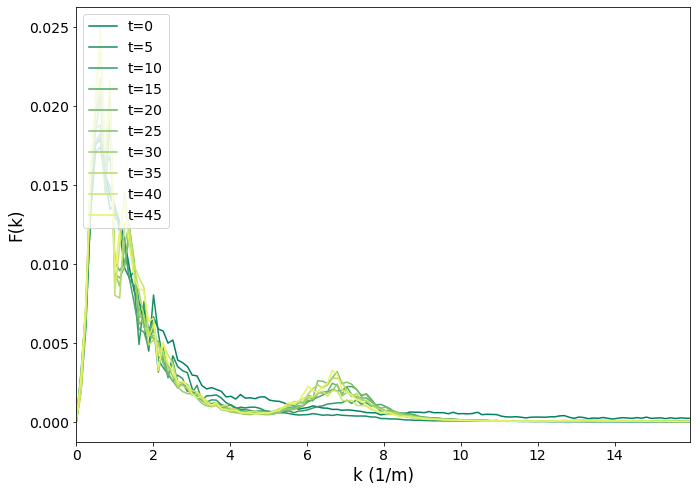

In [282]:
# Define the integration routine
from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_integration(eta):
    L = 50; N = 256
    spectrum = np.fft.fft2(eta)*(1/N)**2 # How to normalize here?!
    F = np.absolute(spectrum)
    F_center = np.fft.fftshift(F)
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    kx = np.fft.fftshift(wavenumber)
    ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    theta = np.arange(-N/4,N/4)/(N)*2*np.pi
    k = wavenumber[0:int(N/2)]
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    #f = interpolate.RectBivariateSpline(kx, ky, F_center)
    #F_center_polar = f.ev(kxp_tile, kyp_tile)
    F_center_polar = griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), 
                       method='nearest')
    F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])*k
    return F_center_polar_integrated*2 # Fold?

# Repeatedly do so for 50 snapshot
N = 256
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
file_common = '/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_256_32modes/surface/eta_matrix_'
F_center_list = []; F_k_list = []; aver = [];
for i in range(0,50,5):    
    pfile = file_common + '%g' % i
    eta = np.fromfile(pfile, dtype=np.float32)
    eta = eta.reshape(N+1,N+1)
    eta = eta[1:,1:]
    aver.append(np.average(eta))
    F_kmod = spectrum_integration(eta)
    F_k_list.append(F_kmod)
    plt.plot(k[0:int(N/2)],F_kmod, color=plt.cm.get_cmap('summer')(i/50), label='t=%g' %i)

plt.xlim([0, wavenumber[int(N/2)-1]])
plt.xlabel('k (1/m)'); plt.ylabel('F(k)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(11,8)

In [284]:
2*np.pi*50/256*4

4.908738521234052

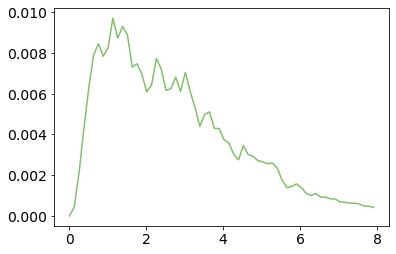

In [265]:
file_common = '/home/jiarong/research/projects/multilayer/testing/multigrid_5layer_128_broaderangle/surface/eta_matrix_'
pfile = file_common + '%g' % 2
eta = np.fromfile(pfile, dtype=np.float32)
eta = eta.reshape(N+1,N+1)
eta = eta[1:,1:]
L = 50; N = 128
spectrum = np.fft.fft2(eta)*(1/N)**2 # How to normalize here?!
F = np.absolute(spectrum)
F_center = np.fft.fftshift(F)
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
kx = np.fft.fftshift(wavenumber)
ky = kx
kx_tile, ky_tile = np.meshgrid(kx,ky)
theta = np.arange(-N/4,N/4)/(N)*2*np.pi
k = wavenumber[0:int(N/2)]
k_tile, theta_tile = np.meshgrid(k,theta)
kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
f = interpolate.RectBivariateSpline(kx, ky, F_center)
F_center_polar = f.ev(kxp_tile, kyp_tile)
F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])*k
plt.plot(k[0:int(N/2)],F_center_polar_integrated, color=plt.cm.get_cmap('summer')(i/18), label='t=%g' %i)

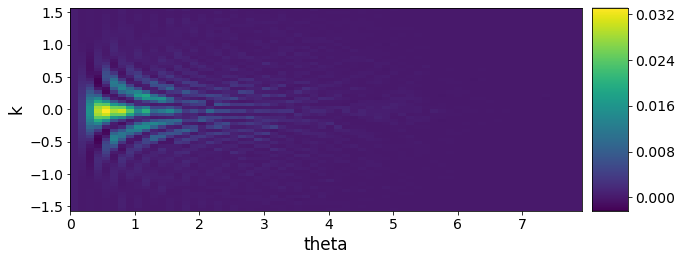

In [266]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10,4))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,1),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
pcontour = grid[0].imshow(F_center_polar, extent=[k[0],k[-1],-1/2*np.pi,1/2*np.pi])
grid[0].set_xlabel('theta'); grid[0].set_ylabel('k')
grid[0].cax.colorbar(pcontour)

In [262]:
theta = np.arange(-N/4,N/4)/(N)*2*np.pi
theta

array([-1.57079633, -1.52170894, -1.47262156, -1.42353417, -1.37444679,
       -1.3253594 , -1.27627202, -1.22718463, -1.17809725, -1.12900986,
       -1.07992247, -1.03083509, -0.9817477 , -0.93266032, -0.88357293,
       -0.83448555, -0.78539816, -0.73631078, -0.68722339, -0.63813601,
       -0.58904862, -0.53996124, -0.49087385, -0.44178647, -0.39269908,
       -0.3436117 , -0.29452431, -0.24543693, -0.19634954, -0.14726216,
       -0.09817477, -0.04908739,  0.        ,  0.04908739,  0.09817477,
        0.14726216,  0.19634954,  0.24543693,  0.29452431,  0.3436117 ,
        0.39269908,  0.44178647,  0.49087385,  0.53996124,  0.58904862,
        0.63813601,  0.68722339,  0.73631078,  0.78539816,  0.83448555,
        0.88357293,  0.93266032,  0.9817477 ,  1.03083509,  1.07992247,
        1.12900986,  1.17809725,  1.22718463,  1.27627202,  1.3253594 ,
        1.37444679,  1.42353417,  1.47262156,  1.52170894])

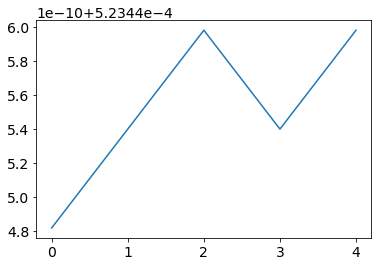

In [130]:
plt.plot(aver)

Text(0.5, 1.0, 't = 40')

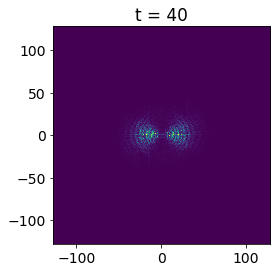

In [138]:
plt.imshow(np.rot90(F_center_list[4]), extent = [-128, 128, -128, 128])
plt.title('t = 40')